# تحلیل داده‌های فالکون ۹ و پیش‌بینی موفقیت فرود

در این نوتبوک، ما داده‌های مربوط به پرتاب‌های راکت فالکون ۹ شرکت اسپیس‌ایکس را تحلیل می‌کنیم و مدلی برای پیش‌بینی موفقیت فرود راکت می‌سازیم.

## ۱. بارگذاری کتابخانه‌های لازم

In [23]:
# بارگذاری کتابخانه‌های مورد نیاز
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# تنظیمات نمایش
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## ۲. بارگذاری داده‌ها

In [24]:
# بارگذاری داده‌ها
df = pd.read_csv('data_falcon9.csv')

# بررسی اولیه داده‌ها
print("ابعاد داده‌ها:", df.shape)
df.head()

ابعاد داده‌ها: (90, 17)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


In [25]:
# بررسی اطلاعات داده‌ها
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     85 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

In [26]:
# بررسی آماری داده‌ها
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,90.000000,85.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6123.547647,1.788889,3.500000,3.188889,-86.366477,29.449963
std,26.124701,4870.916417,1.213172,1.595288,4.194417,14.149518,2.141306
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857
25%,23.250000,2482.000000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,45.500000,4535.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,67.750000,9600.000000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,90.000000,15600.000000,6.000000,5.000000,13.000000,-80.577366,34.632093


## ۳. پیش‌پردازش و تمیز کردن داده‌ها

In [27]:
# بررسی مقادیر گمشده
print("تعداد مقادیر گمشده در هر ستون:")
print(df.isnull().sum())

تعداد مقادیر گمشده در هر ستون:
FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64


In [28]:
# بررسی ستون Outcome برای تعیین موفقیت فرود
print("مقادیر منحصر به فرد در ستون Outcome:")
df['Outcome'].unique()

مقادیر منحصر به فرد در ستون Outcome:


array(['None None', 'False Ocean', 'True Ocean', 'False ASDS',
       'None ASDS', 'True RTLS', 'True ASDS', 'False RTLS'], dtype=object)

In [29]:
# ایجاد یک ستون هدف برای تعیین موفقیت فرود
def get_landing_outcome(outcome):
    if outcome is np.nan:
        return 0
    elif outcome.startswith('True'):
        return 1
    else:
        return 0

df['Success'] = df['Outcome'].apply(get_landing_outcome)

# نمایش توزیع ستون هدف
print("توزیع موفقیت فرود:")
print(df['Success'].value_counts())
print(f"نسبت موفقیت: {df['Success'].mean():.2f}")

توزیع موفقیت فرود:
Success
1    60
0    30
Name: count, dtype: int64
نسبت موفقیت: 0.67


In [30]:
# پردازش ستون تاریخ
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# مقدار میانه را برای مقادیر گمشده در PayloadMass استفاده می‌کنیم
df['PayloadMass'].fillna(df['PayloadMass'].median(), inplace=True)

# تبدیل ستون‌های بولین به عددی
boolean_columns = ['GridFins', 'Reused', 'Legs']
for col in boolean_columns:
    df[col] = df[col].astype(int)

C:\Users\aliah\AppData\Local\Temp\ipykernel_3724\327394636.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['PayloadMass'].fillna(df['PayloadMass'].median(), inplace=True)


## ۴. تحلیل و مصورسازی داده‌ها

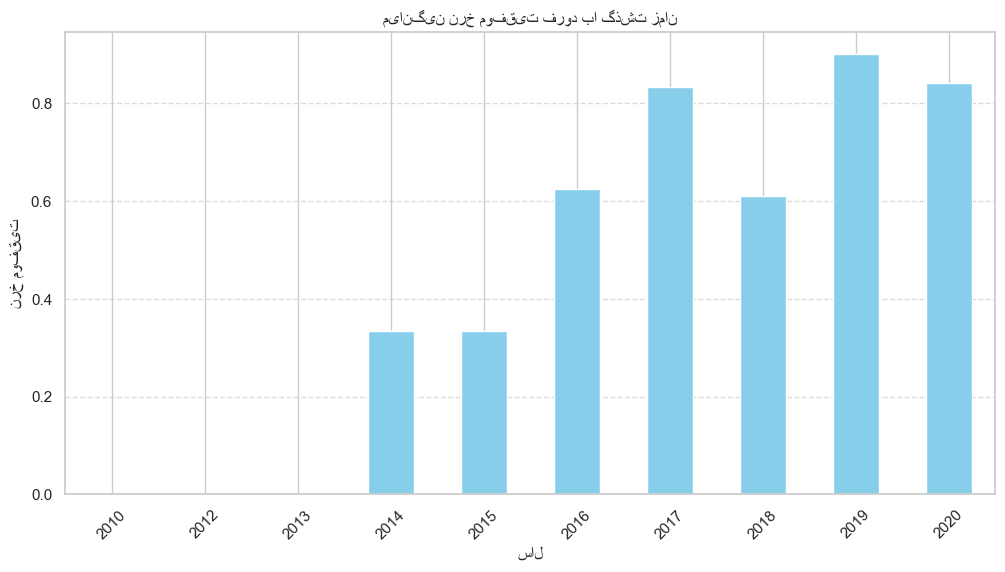

In [31]:
# نمودار میزان موفقیت با گذشت زمان
yearly_success = df.groupby('Year')['Success'].mean()
plt.figure(figsize=(12, 6))
yearly_success.plot(kind='bar', color='skyblue')
plt.title('میانگین نرخ موفقیت فرود با گذشت زمان')
plt.xlabel('سال')
plt.ylabel('نرخ موفقیت')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

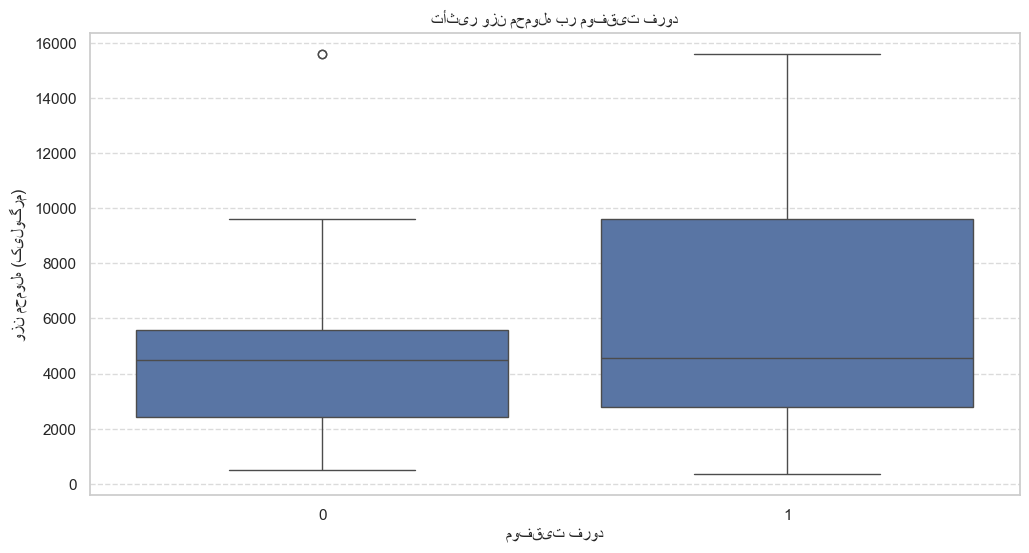

In [32]:
# بررسی تأثیر وزن محموله بر موفقیت فرود
plt.figure(figsize=(12, 6))
sns.boxplot(x='Success', y='PayloadMass', data=df)
plt.title('تأثیر وزن محموله بر موفقیت فرود')
plt.xlabel('موفقیت فرود')
plt.ylabel('وزن محموله (کیلوگرم)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

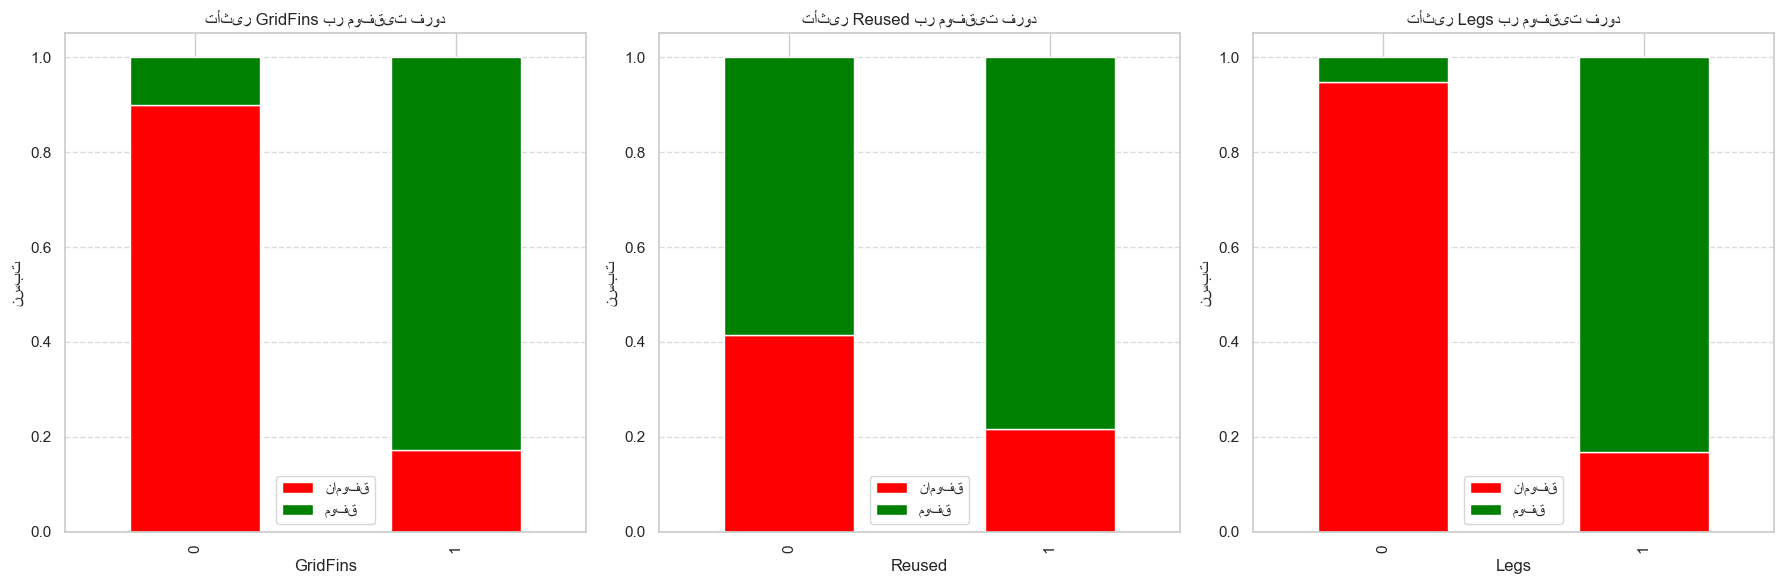

In [33]:
# بررسی تأثیر وجود GridFins، استفاده مجدد و Legs بر موفقیت
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(boolean_columns):
    crosstab = pd.crosstab(df[col], df['Success'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], color=['red', 'green'])
    axes[i].set_title(f'تأثیر {col} بر موفقیت فرود')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('نسبت')
    axes[i].legend(['ناموفق', 'موفق'])
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()

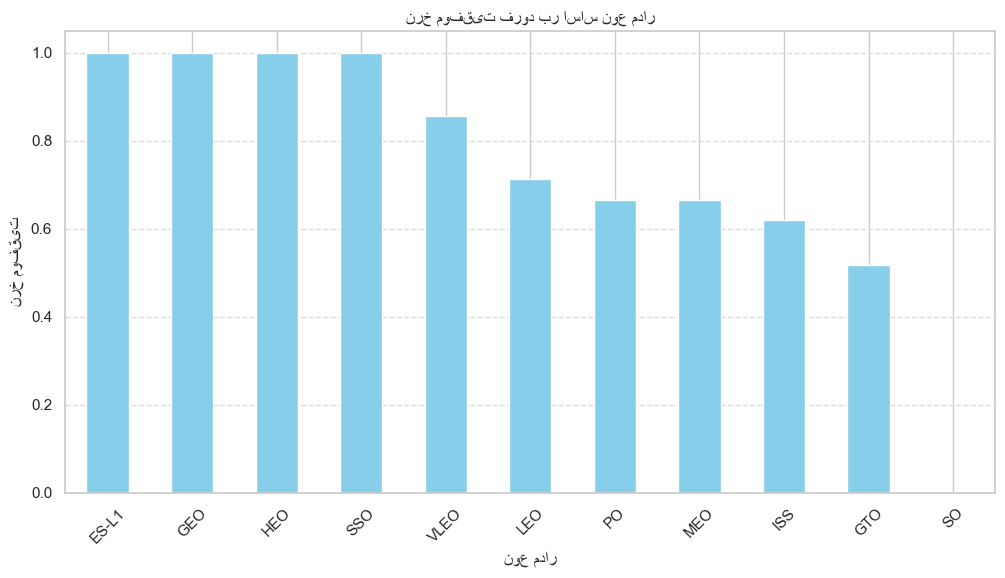

In [34]:
# بررسی تأثیر نوع مدار بر موفقیت فرود
orbit_success = df.groupby('Orbit')['Success'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
orbit_success.plot(kind='bar', color='skyblue')
plt.title('نرخ موفقیت فرود بر اساس نوع مدار')
plt.xlabel('نوع مدار')
plt.ylabel('نرخ موفقیت')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

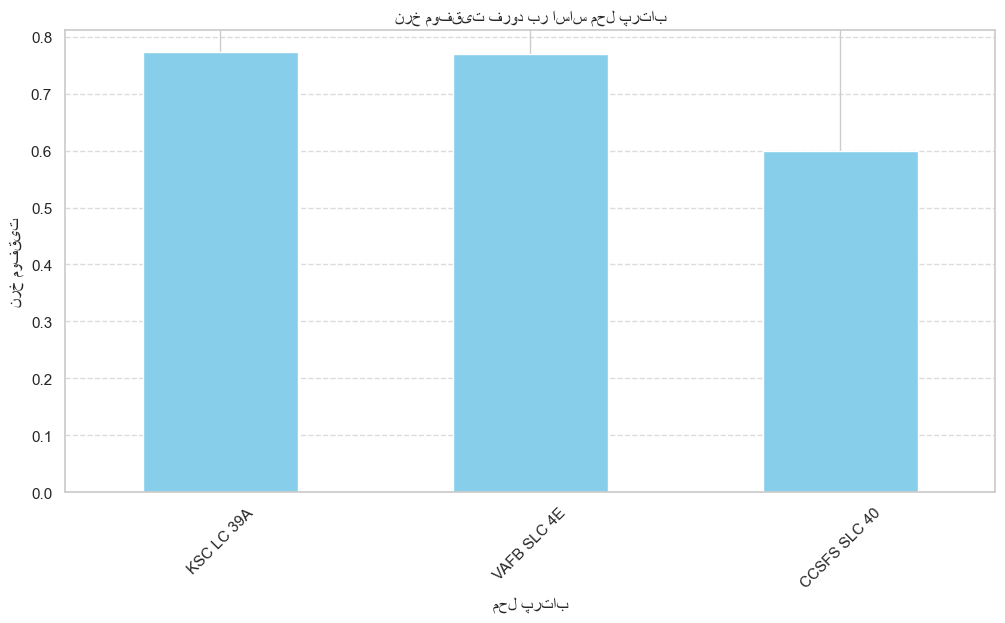

In [35]:
# بررسی تأثیر محل پرتاب بر موفقیت فرود
launch_site_success = df.groupby('LaunchSite')['Success'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
launch_site_success.plot(kind='bar', color='skyblue')
plt.title('نرخ موفقیت فرود بر اساس محل پرتاب')
plt.xlabel('محل پرتاب')
plt.ylabel('نرخ موفقیت')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

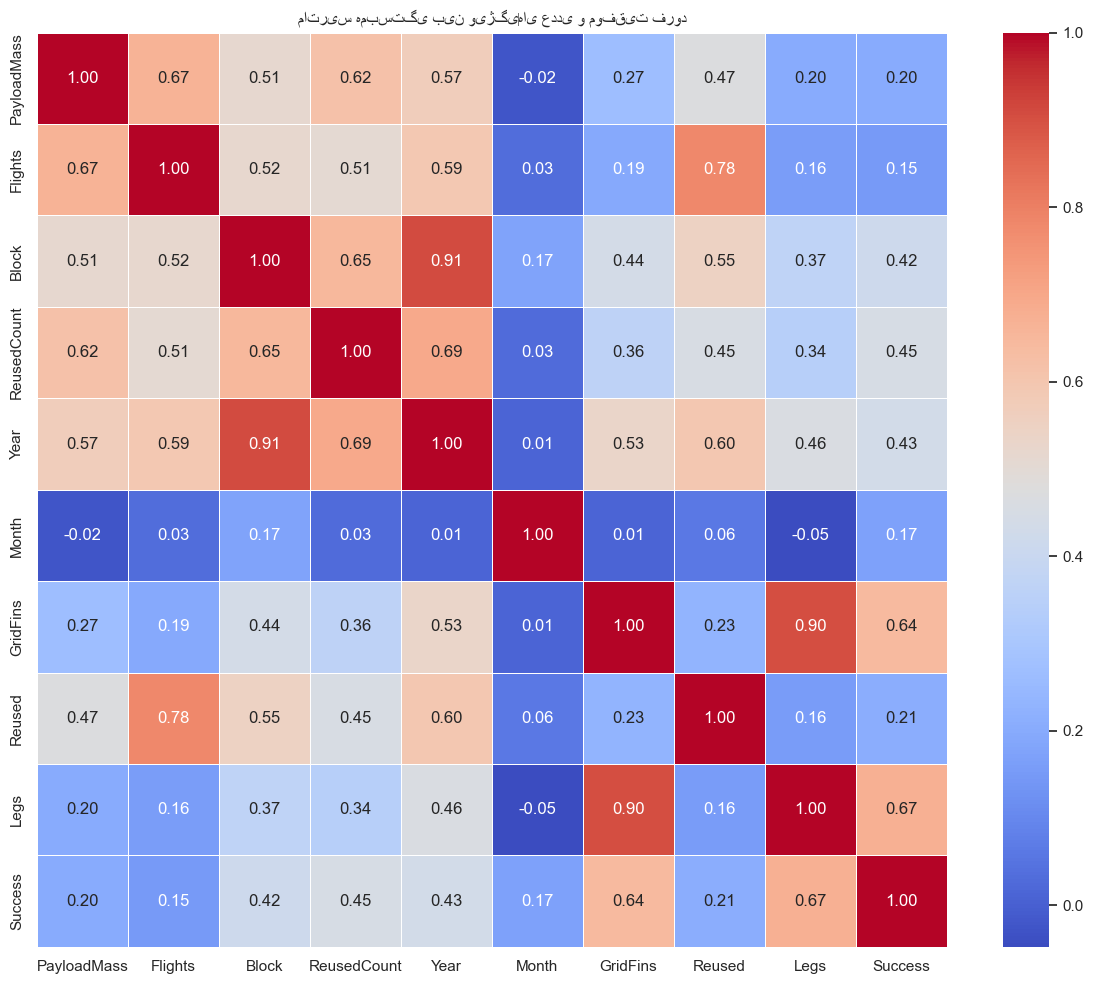

In [36]:
# ماتریس همبستگی برای ویژگی‌های عددی
numerical_features = ['PayloadMass', 'Flights', 'Block', 'ReusedCount', 'Year', 'Month', 'GridFins', 'Reused', 'Legs']
correlation_matrix = df[numerical_features + ['Success']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('ماتریس همبستگی بین ویژگی‌های عددی و موفقیت فرود')
plt.tight_layout()
plt.show()

## ۵. آماده‌سازی داده‌ها برای مدل‌سازی

In [37]:
# انتخاب ویژگی‌ها
features = ['PayloadMass', 'Orbit', 'LaunchSite', 'GridFins', 'Reused', 'Legs', 'Block', 'ReusedCount', 'Year', 'Month']
X = df[features]
y = df['Success']

# تقسیم داده‌ها به داده‌های آموزش و آزمون
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
# شناسایی ویژگی‌های عددی و کتگوریکال
numerical_features = ['PayloadMass', 'Block', 'ReusedCount', 'Year', 'Month']
categorical_features = ['Orbit', 'LaunchSite']
boolean_features = ['GridFins', 'Reused', 'Legs']

# تعریف پایپ‌لاین پیش‌پردازش
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# ترکیب همه ترنسفورمرها
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features)
    ])

# تعریف پایپ‌لاین مدل
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

## ۶. آموزش مدل و ارزیابی

دقت مدل: 0.8333

گزارش طبقه‌بندی:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.85      0.92      0.88        12

    accuracy                           0.83        18
   macro avg       0.82      0.79      0.80        18
weighted avg       0.83      0.83      0.83        18



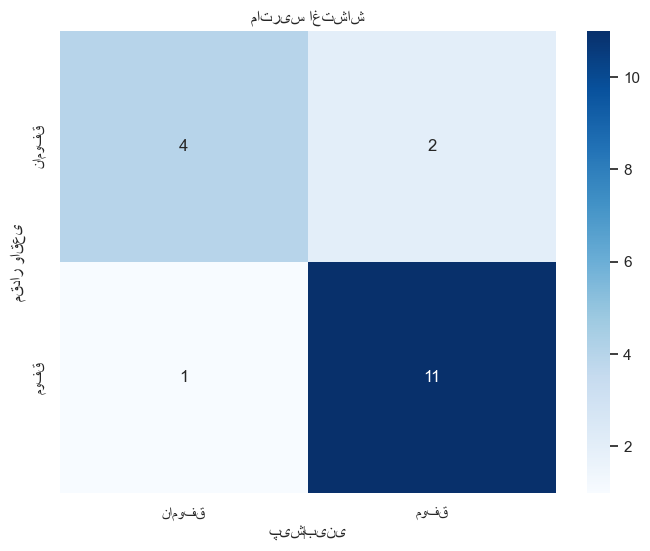

In [39]:
# آموزش مدل
model.fit(X_train, y_train)

# پیش‌بینی روی داده‌های آزمون
y_pred = model.predict(X_test)

# ارزیابی مدل
accuracy = accuracy_score(y_test, y_pred)
print(f"دقت مدل: {accuracy:.4f}")

# گزارش طبقه‌بندی
print("\nگزارش طبقه‌بندی:")
print(classification_report(y_test, y_pred))

# ماتریس اغتشاش
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ناموفق', 'موفق'], 
            yticklabels=['ناموفق', 'موفق'])
plt.title('ماتریس اغتشاش')
plt.xlabel('پیش‌بینی')
plt.ylabel('مقدار واقعی')
plt.show()

## ۷. بررسی اهمیت ویژگی‌ها

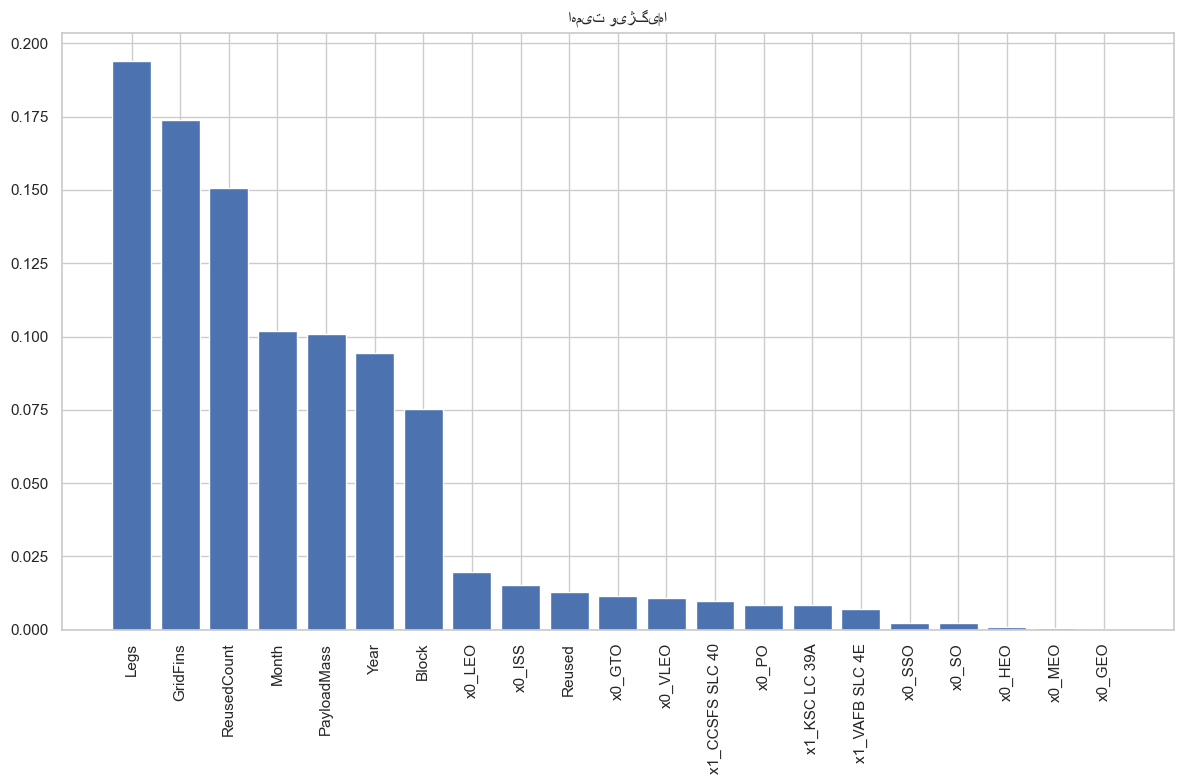

In [40]:
# استخراج ضرایب اهمیت ویژگی‌ها
feature_names = (model.named_steps['preprocessor']
                  .transformers_[0][1].named_steps['imputer']
                  .feature_names_in_.tolist() + 
                 model.named_steps['preprocessor']
                  .transformers_[1][1].named_steps['onehot']
                  .get_feature_names_out().tolist() + 
                 model.named_steps['preprocessor']
                  .transformers_[2][1].named_steps['imputer']
                  .feature_names_in_.tolist())

importances = model.named_steps['classifier'].feature_importances_

# مرتب‌سازی ویژگی‌ها بر اساس اهمیت
indices = np.argsort(importances)[::-1]

# نمایش اهمیت ویژگی‌ها
plt.figure(figsize=(12, 8))
plt.title('اهمیت ویژگی‌ها')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## ۸. پیش‌بینی برای داده‌های جدید

In [41]:
# ایجاد تابع برای پیش‌بینی موفقیت پرتاب جدید
def predict_launch_success(payload_mass, orbit, launch_site, grid_fins, reused, legs, block, reused_count, year, month):
    # ایجاد دیتافریم از داده‌های ورودی
    input_data = pd.DataFrame({
        'PayloadMass': [payload_mass],
        'Orbit': [orbit],
        'LaunchSite': [launch_site],
        'GridFins': [grid_fins],
        'Reused': [reused],
        'Legs': [legs],
        'Block': [block],
        'ReusedCount': [reused_count],
        'Year': [year],
        'Month': [month]
    })
    
    # پیش‌بینی
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)
    
    return prediction[0], probability[0][1]

# مثال استفاده از تابع پیش‌بینی
# یک نمونه فرضی
success, prob = predict_launch_success(
    payload_mass=5000,  # وزن محموله به کیلوگرم
    orbit='LEO',        # نوع مدار
    launch_site='KSC LC 39A',  # محل پرتاب
    grid_fins=1,        # آیا GridFins دارد؟
    reused=1,           # آیا قبلاً استفاده شده؟
    legs=1,             # آیا پایه‌های فرود دارد؟
    block=5.0,          # نسخه بلوک
    reused_count=2,     # تعداد استفاده‌های قبلی
    year=2022,          # سال پرتاب
    month=6             # ماه پرتاب
)

print(f"نتیجه پیش‌بینی: {'موفق' if success == 1 else 'ناموفق'}")
print(f"احتمال موفقیت: {prob:.2%}")

نتیجه پیش‌بینی: موفق
احتمال موفقیت: 93.00%


## ۹. نتیجه‌گیری

در این نوتبوک، ما مراحل زیر را انجام دادیم:

1. داده‌های پرتاب‌های فالکون ۹ را بارگذاری و تمیز کردیم.
2. تحلیل و مصورسازی برای درک بهتر داده‌ها انجام دادیم.
3. ویژگی‌های مهم را شناسایی کردیم.
4. یک مدل جنگل تصادفی برای پیش‌بینی موفقیت فرود بوستر ساختیم.
5. مدل را ارزیابی کردیم و اهمیت ویژگی‌ها را بررسی کردیم.
6. تابعی برای پیش‌بینی موفقیت پرتاب‌های جدید ایجاد کردیم.

این تحلیل نشان می‌دهد که عوامل متعددی مانند نوع مدار، وجود GridFins و Legs، و نسخه بوستر تأثیر قابل توجهی بر موفقیت فرود دارند. با استفاده از این مدل، می‌توان احتمال موفقیت فرود بوستر را در پرتاب‌های آینده پیش‌بینی کرد.